In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
!pip install category_encoders
!pip install scikit-learn
!pip install imblearn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 2.0 MB/s eta 0:00:00


In [ ]:
# Cell 3: Import libraries
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import RobustScaler
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
from category_encoders import BinaryEncoder  # Changed from TargetEncoder
import time
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import learning_curve

In [ ]:
path = "/content/drive/MyDrive/zip fo/cleanedtrain_data.csv"
df = pd.read_csv(path)

In [ ]:
# Cell 5: Check columns
print(df.columns)

# Cell 6: Preprocessing with Binary Encoding
# Separate features and target
X = df.drop(columns=['cluster_category'])  # Adjust target column name
y = df['cluster_category'].astype(int)

Index(['Customer_ID', 'outlet_city', 'luxury_sales', 'fresh_sales',
       'dry_sales', 'cluster_category'],
      dtype='object')


In [ ]:
# Binary encode 'outlet_city'
binary_encoder = BinaryEncoder(cols=['outlet_city'])
X_encoded = binary_encoder.fit_transform(X['outlet_city'])  # Transform 'outlet_city' to binary columns
X = X.drop(columns=['outlet_city'])  # Drop original column
X = pd.concat([X, X_encoded], axis=1)  # Add binary encoded columns

In [ ]:
# Apply RobustScaler to numerical features
scaler = RobustScaler()
numerical_features = ['luxury_sales', 'fresh_sales', 'dry_sales']  # Adjust feature names
X[numerical_features] = scaler.fit_transform(X[numerical_features])

In [ ]:
# Inspect preprocessed data
print("\nPreprocessed X Preview:\n", X.head())
print("Shape of X:", X.shape)


Preprocessed X Preview:
    Customer_ID  luxury_sales  fresh_sales  dry_sales  outlet_city_0  \
0   10493832.0     -0.439830    -0.449339   0.324965              0   
1   10178643.0     -0.074139    -0.391966   0.452208              0   
2   10513916.0      0.597391    -0.312540   1.012410              0   
3   10334589.0      0.583994    -0.263745   1.002488              0   
4   10458365.0      0.651795    -0.201502   1.028152              0   

   outlet_city_1  outlet_city_2  outlet_city_3  outlet_city_4  
0              0              0              0              1  
1              0              0              1              0  
2              0              0              1              1  
3              0              0              1              1  
4              0              0              0              1  
Shape of X: (739088, 9)


In [ ]:
# Split data and apply transformations
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

In [ ]:
# Re-scale numerical features on training data only to prevent leakage
from sklearn.preprocessing import StandardScaler  # or MinMaxScaler, RobustScaler, etc.
scaler = StandardScaler()  # Define the scaler
X_train[numerical_features] = scaler.fit_transform(X_train[numerical_features])
X_test[numerical_features] = scaler.transform(X_test[numerical_features])

In [ ]:
# Inspect the split
print("\nTraining set shape:", X_train.shape)
print("Test set shape:", X_test.shape)
print("\nClass distribution in y_train:\n", y_train.value_counts())


Training set shape: (517361, 9)
Test set shape: (221727, 9)

Class distribution in y_train:
 cluster_category
1    132285
4    120702
6    118446
2    108542
5     20507
3     16879
Name: count, dtype: int64


In [ ]:
# Cell 8: Check imbalance and apply SMOTE if needed
minority_ratio = y_train.value_counts().min() / y_train.value_counts().max()
print("\nMinority ratio (min/max class):", minority_ratio)

use_smote = minority_ratio < 0.1  # Adjust threshold as needed
if use_smote:
    start_time = time.time()
    smote = SMOTE(random_state=42)
    X_train, y_train = smote.fit_resample(X_train, y_train)
    print(f"\nSMOTE processing time: {time.time() - start_time:.2f} seconds")
    print("\nResampled class distribution:\n", y_train.value_counts())
    y_train = y_train.astype(int)
else:
    print("\nSMOTE skipped due to sufficient balance.")


Minority ratio (min/max class): 0.1275957213591866

SMOTE skipped due to sufficient balance.


In [ ]:
#Grid Search with Logistic Regression
param_grid = {
    'C': [0.01, 0.1, 1],
    'max_iter': [500, 1000]
}
grid_search = GridSearchCV(LogisticRegression(multi_class='multinomial', class_weight='balanced', random_state=42, n_jobs=-1),
                          param_grid, cv=5, scoring='f1_weighted', n_jobs=-1)
start_time = time.time()
grid_search.fit(X_train, y_train)
print(f"\nGrid Search time: {(time.time() - start_time) / 60:.2f} minutes")


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(



Grid Search time: 0.86 minutes


In [ ]:
# Best model
print("\nBest parameters:", grid_search.best_params_)
best_log_reg = grid_search.best_estimator_
y_pred_best = best_log_reg.predict(X_test)
print("\nBest Logistic Regression Accuracy:", accuracy_score(y_test, y_pred_best))
print("\nClassification Report:\n", classification_report(y_test, y_pred_best))


Best parameters: {'C': 0.1, 'max_iter': 500}

Best Logistic Regression Accuracy: 0.8399698728616722

Classification Report:
               precision    recall  f1-score   support

           1       0.96      0.87      0.91     56694
           2       0.72      0.74      0.73     46518
           3       1.00      0.90      0.95      7233
           4       0.87      0.96      0.91     51730
           5       0.90      0.99      0.94      8789
           6       0.76      0.74      0.75     50763

    accuracy                           0.84    221727
   macro avg       0.87      0.87      0.87    221727
weighted avg       0.84      0.84      0.84    221727



In [ ]:
# Cell 10: Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred_best)
print("\nConfusion Matrix:\n", conf_matrix)


Confusion Matrix:
 [[49250     4     1  7435     2     2]
 [    1 34566     2     3     0 11946]
 [    1     0  6517    10   703     2]
 [ 1871     1     2 49599   256     1]
 [    1     0     2    52  8731     3]
 [    1 13174     4     2     1 37581]]


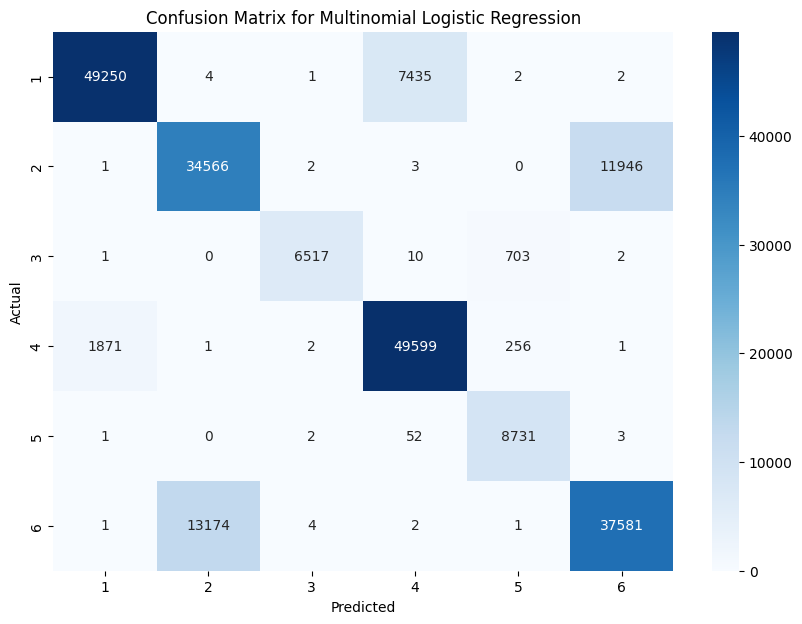

In [ ]:
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=range(1, 7), yticklabels=range(1, 7))
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for Multinomial Logistic Regression')
plt.show()

In [ ]:
#  Manual Accuracy Check
train_pred_manual = best_log_reg.predict(X_train)  # Changed to best_log_reg
test_pred_manual = best_log_reg.predict(X_test)
train_acc_manual = accuracy_score(y_train, train_pred_manual)
test_acc_manual = accuracy_score(y_test, test_pred_manual)
print("\nTraining Accuracy (Manual):", train_acc_manual)
print("Test Accuracy (Manual):", test_acc_manual)
print("Overfitting Gap (Train - Test):", train_acc_manual - test_acc_manual)


Training Accuracy (Manual): 0.8384203679828979
Test Accuracy (Manual): 0.8399698728616722
Overfitting Gap (Train - Test): -0.001549504878774366


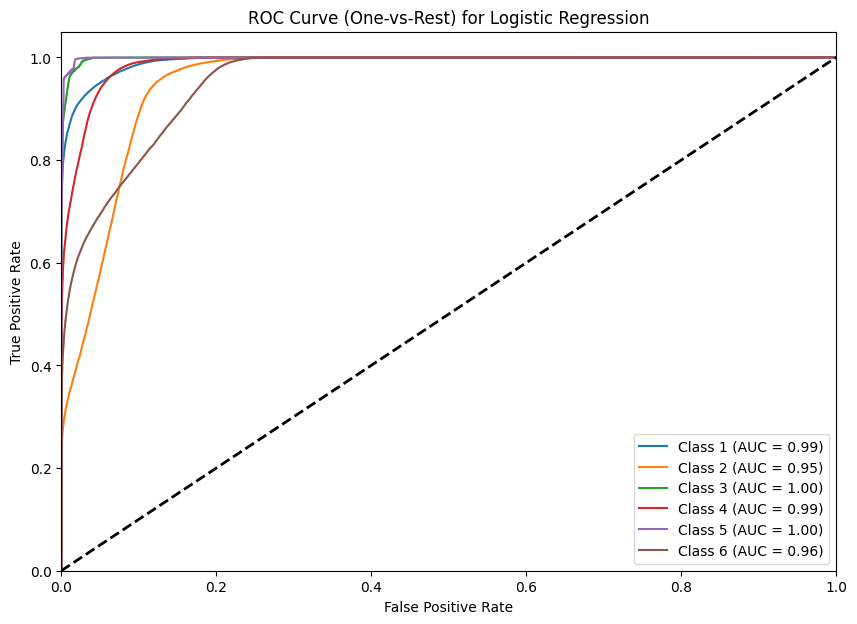

In [ ]:
#  ROC Curve (Multi-class)
plt.figure(figsize=(10, 7))
y_test_bin = pd.get_dummies(y_test)  # Convert to one-hot encoding for ROC
for i in range(6):  # 6 classes (1 to 6)
    fpr, tpr, _ = roc_curve(y_test_bin.iloc[:, i], best_log_reg.predict_proba(X_test)[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'Class {i+1} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (One-vs-Rest) for Logistic Regression')
plt.legend(loc="lower right")
plt.show()

/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
1 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.11/dist-packages/sklearn/base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py", line 1301, in fit
    raise ValueError(
ValueE

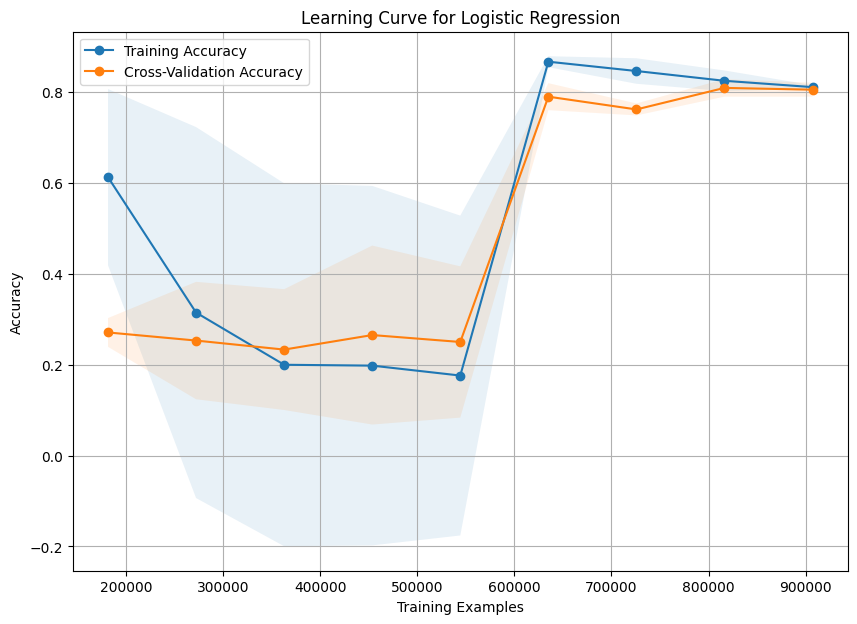

In [ ]:
# Cell 13: Learning Curve (Updated)
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)
train_sizes, train_scores, test_scores = learning_curve(
    best_log_reg, X_resampled, y_resampled, cv=5, n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 10), scoring='accuracy'
)
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.figure(figsize=(10, 7))
plt.plot(train_sizes, train_mean, label='Training Accuracy', marker='o')
plt.plot(train_sizes, test_mean, label='Cross-Validation Accuracy', marker='o')
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1)
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.1)
plt.xlabel('Training Examples')
plt.ylabel('Accuracy')
plt.title('Learning Curve for Logistic Regression')
plt.legend(loc='best')
plt.grid()
plt.show()